# Subblock Detection with YOLOv8 on Apple MPS

Welcome to the **Subblock Detection** notebook! Here we walk through the full lifecycle of training and evaluating an Ultralytics YOLOv8 detector on your custom circuit‐subblock dataset, all on Apple’s MPS backend. You can follow along section by section:

---

## 📁 1. Environment & Dataset Prep  
- **Locate project root** and dependencies  
- **Run** `prepare_subblock_dataset.py` to assemble images + labels  
- Create a `trained_models/` folder to store checkpoints & CSV metrics

## 🔧 2. Configuration & Helpers  
- Set paths (`DATA_YAML`, `ORIG_MODEL`, etc.) and hyperparameters (epochs, batch size, image size)  
- Toggle training flags (`RUN_STAGE1` / `RUN_STAGE2`)  
- Utility functions:  
  - `get_checkpoint()` finds `.pt` files  
  - `load_metrics()` reads per‐epoch results into pandas

## 🚀 3. Stage 1: Frozen Warm-Up  
- Train the last layers for **30 epochs** (`freeze=10`)  
- Save best weights & epoch‐wise metrics

## 🔄 4. Stage 2: Full Fine-Tuning  
- Unfreeze all layers and train **20 more epochs** (`freeze=0`)  
- Save best weights & metrics  
- Plot the combined mAP@0.5 & mAP@0.5-0.95 curves across 1…50 epochs

## 🔍 5. Parameter Sweep  
- (Dry-run mode) quickly test a grid of hyperparameters for **1 epoch**  
- Once validated, flip `DRY_RUN=False` to run full **20 epoch** fine-tunes  
- Collect and compare final‐epoch metrics in a summary table  
- Identify the best variant

## 🎯 6. One-Shot Baseline  
- Train a **single 50-epoch** run from the original pretrained model (`freeze=0`)  
- Compare its performance vs. the two-stage pipeline

## 📊 7. Final Evaluation & Plots  
- Build a **test-set comparison table** of:  
  - Stage1+2 default  
  - One-Shot baseline  
  - Best-tuned sweep run  
- Plot **epoch-wise mAP** for each experiment  
- Zoom in on the fine-tune window (epochs 31–50) to visualize differences

---

## ▶️ How to Follow This Notebook  
1. **Execute cells in order.** Each section depends on artifacts or variables defined earlier.  
2. **Toggle flags** at the top (e.g. `RUN_STAGE1`, `DRY_RUN`) to skip or shorten expensive training steps when iterating.  
3. **Inspect outputs** in the `trained_models/` folder—checkpoints (`.pt`) and metrics (`*_metrics.csv`).  
4. **Adjust hyperparameters** in the parameter‐sweep section to explore other training recipes.  
5. **Use the final detection snippet** at the end to integrate your best model into downstream analysis.

> ⚠️ **Note:** If you ever re-run Stage 1 or Stage 2 under the same run name, delete the old `runs/detect/{run_name}` folder (or change the run name) to avoid appending duplicate epochs in your metrics.

Enjoy experimenting, and happy detecting! 🛠️🔎  


In [ ]:
# Cell 0: Dataset preparation & setup

import subprocess, sys
from pathlib import Path

# 1) Locate project root by finding 'subblock_detect' folder
cwd = Path().resolve()
for p in [cwd] + list(cwd.parents):
    if (p / "subblock_detect").is_dir():
        proj_root = p
        break
else:
    raise FileNotFoundError("Could not find project root containing 'subblock_detect/'")

# 2) Run the prepare_subblock_dataset.py script
prep_script = proj_root / "subblock_detect" / "scripts" / "prepare_subblock_dataset.py"
print(f"⏳ Running dataset prep script at {prep_script}")
proc = subprocess.run([sys.executable, str(prep_script)],
                      cwd=str(proj_root),
                      capture_output=True, text=True)
print("STDOUT:\n", proc.stdout)
print("STDERR:\n", proc.stderr)
if proc.returncode != 0:
    raise RuntimeError("Dataset preparation failed; see STDERR above.")

# 3) Ensure trained_models/ directory exists
trained_dir = proj_root / "trained_models"
trained_dir.mkdir(exist_ok=True)
print(f"✅ Prepared dataset and ensured trained_models directory at {trained_dir}")


⏳ Running dataset prep script at /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/scripts/prepare_subblock_dataset.py
STDOUT:
 Found 426 JSON files in /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/data/to_label_images
Generated 425 YOLO label files in /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/labels/to_label
Preparing splits for 424 labeled images
 -> train: 339 images
 -> val: 42 images
 -> test: 43 images
✅ Dataset preparation complete. YAML written to /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml

STDERR:
 
✅ Prepared dataset and ensured trained_models directory at /Users/fatihbasturk/Projects/EE58A-2025/trained_models


In [13]:
# Cell 1: Imports, Configuration & Utilities

import yaml
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

# 1) Project root already found in Cell 0, reuse:
#    proj_root, trained_dir

# 2) Paths & hyperparameters
DATA_YAML   = str(proj_root / "subblock_detect" / "config" / "subblock_data.yaml")
ORIG_MODEL  = str(trained_dir   / "yolov8_original.pt")  # ensure you have placed your 12-class .pt here
DEVICE      = "mps"           # or 'cpu' / 'cuda:0'
STAGE1_NAME = "exp_stage1"
STAGE2_NAME = "exp_stage2"
EPOCHS1     = 30
EPOCHS2     = 20
IMG_SIZE    = 640
BATCH_SIZE  = 16

# 3) Control flags
RUN_STAGE1 = False  # set True to train stage1
RUN_STAGE2 =False # set True to train stage2

# 4) Load class names from DATA_YAML
with open(DATA_YAML) as f:
    data_cfg = yaml.safe_load(f)
CLASS_NAMES = data_cfg["names"]
print("DATA_YAML:", DATA_YAML)
print("Classes:", CLASS_NAMES)

# 5) Utility to locate checkpoint
def get_checkpoint(run_name, best=True):
    wdir = proj_root / "runs" / "detect" / run_name / "weights"
    best_ckpt = wdir / "best.pt"
    last_ckpt = wdir / "last.pt"
    if best and best_ckpt.exists(): return str(best_ckpt)
    if last_ckpt.exists(): 
        print(f"⚠️ best.pt not found for {run_name}, using last.pt")
        return str(last_ckpt)
    raise FileNotFoundError(f"No checkpoint for run {run_name}")

def load_metrics(run_name):
    """
    Load the Ultralytics results.csv for a given run.
    """
    path = proj_root / "runs" / "detect" / run_name / "results.csv"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    df = pd.read_csv(path)
    # Rename columns to match expected keys
    df = df.rename(columns={"map50": "mAP50", "map50-95": "mAP50-95"})
    return df.set_index("epoch")

print("load_metrics now reads results.csv")


DATA_YAML: /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml
Classes: ['differential_pair', 'cascode', 'current_mirror']
load_metrics now reads results.csv


In [14]:
# Cell 2: Stage 1 Training & Artifact Saving

from ultralytics import YOLO
import shutil, os, torch

# 🔧 1) MPS tweaks: set env var before any MPS allocator use
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

# 🔧 2) Clear out any leftover MPS cache
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# 1) Initialize model
model1 = YOLO(ORIG_MODEL)

# 2) Train (if flag enabled)
if RUN_STAGE1:
    print(f"▶️ Starting Stage 1 training for {EPOCHS1} epochs…")
    stage1 = model1.train(
        data=DATA_YAML,
        epochs=EPOCHS1,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        freeze=10,
        device=DEVICE,
        name=STAGE1_NAME,
        save=True,
        exist_ok=True,
        verbose=False,
        max_det=100
    )
    print("✅ Stage 1 training complete.")
else:
    print("⏭️ Skipping Stage 1 training (RUN_STAGE1=False)")

# 3) Copy out best.pt and results.csv to trained_models/
try:
    ckpt1 = get_checkpoint(STAGE1_NAME)
    dst_w = trained_dir / f"{STAGE1_NAME}_best.pt"
    shutil.copy2(ckpt1, dst_w)
    print(f"✅ Copied Stage1 weights → {dst_w}")

    # Ultralytics writes results.csv, so copy that instead of metrics.csv
    src_m = proj_root / "runs" / "detect" / STAGE1_NAME / "results.csv"
    dst_m = trained_dir / f"{STAGE1_NAME}_metrics.csv"
    shutil.copy2(src_m, dst_m)
    print(f"✅ Copied Stage1 metrics → {dst_m}")
except FileNotFoundError as e:
    print(f"⚠️ Artifact copy skipped: {e}")


⏭️ Skipping Stage 1 training (RUN_STAGE1=False)
✅ Copied Stage1 weights → /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage1_best.pt
✅ Copied Stage1 metrics → /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage1_metrics.csv


In [15]:
# Cell 3: Stage 2 Training & Artifact Saving

from ultralytics import YOLO
import shutil, os, torch

# 🔧 MPS tweaks: ensure high-watermark disabled and cache cleared
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# 1) Locate the Stage 1 checkpoint (best or last)
stage1_ckpt = get_checkpoint(STAGE1_NAME)

# 2) Initialize model for Stage 2
model2 = YOLO(stage1_ckpt)

# 3) Train Stage 2 (if flag enabled)
if RUN_STAGE2:
    print(f"▶️ Starting Stage 2 fine-tune for {EPOCHS2} epochs…")
    stage2 = model2.train(
        data=DATA_YAML,
        epochs=EPOCHS2,
        imgsz=IMG_SIZE,     # ↳ lower to 512 or 416 if you still hit OOM
        batch=BATCH_SIZE,   # ↳ drop to 8 or 4 if needed
        freeze=0,
        device=DEVICE,
        name=STAGE2_NAME,
        save=True,
        exist_ok=True,
        verbose=False,
        max_det=100
    )
    print("✅ Stage 2 training complete.")
else:
    print("⏭️ Skipping Stage 2 training (RUN_STAGE2=False)")

# 4) Copy out Stage2 artifacts
try:
    ckpt2 = get_checkpoint(STAGE2_NAME)
    dst_w2 = trained_dir / f"{STAGE2_NAME}_best.pt"
    shutil.copy2(ckpt2, dst_w2)
    print(f"✅ Copied Stage2 weights → {dst_w2}")

    # Ultralytics writes results.csv, so copy that instead of metrics.csv
    src_m2 = proj_root / "runs" / "detect" / STAGE2_NAME / "results.csv"
    dst_m2 = trained_dir / f"{STAGE2_NAME}_metrics.csv"
    shutil.copy2(src_m2, dst_m2)
    print(f"✅ Copied Stage2 metrics → {dst_m2}")
except FileNotFoundError as e:
    print(f"⚠️ Artifact copy skipped: {e}")


⏭️ Skipping Stage 2 training (RUN_STAGE2=False)
✅ Copied Stage2 weights → /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage2_best.pt
✅ Copied Stage2 metrics → /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage2_metrics.csv


In [43]:
from pathlib import Path

models_dir = Path(trained_dir)
print("Files in trained_models/:")
for f in models_dir.iterdir():
    print(" •", f.name)


Files in trained_models/:
 • exp_lr_5e-4_metrics.csv
 • exp_mixup_on_metrics.csv
 • exp_lr_1e-3_best.pt
 • exp_lr_5e-4_best.pt
 • exp_label_smooth_metrics.csv
 • exp_mosaic_off_metrics.csv
 • exp_wd_1e-3_metrics.csv
 • exp_mixup_on_best.pt
 • yolov8_best.pt
 • exp_wd_1e-4_best.pt
 • exp_lr_1e-4_metrics.csv
 • exp_cosine_lr_metrics.csv
 • exp_orig_full50_metrics.csv
 • exp_cosine_lr_best.pt
 • exp_stage1_metrics.csv
 • exp_wd_1e-2_metrics.csv
 • exp_lr_1e-4_best.pt
 • exp_stage2_best.pt
 • yolov8_original.pt
 • exp_lr_1e-3_metrics.csv
 • exp_stage1_best.pt
 • exp_wd_1e-3_best.pt
 • exp_wd_1e-4_metrics.csv
 • exp_orig_full50_best.pt
 • exp_mosaic_off_best.pt
 • exp_label_smooth_best.pt
 • exp_stage2_metrics.csv
 • exp_wd_1e-2_best.pt


In [18]:
import pandas as pd
from pathlib import Path

# Load the copied metrics from trained_models/
run1_csv = Path(trained_dir) / f"{STAGE1_NAME}_metrics.csv"
run2_csv = Path(trained_dir) / f"{STAGE2_NAME}_metrics.csv"

# Read them in
df1_all = pd.read_csv(run1_csv, index_col="epoch")
df2     = pd.read_csv(run2_csv, index_col="epoch")

# Quick checks
print("Stage1 CSV path:", run1_csv, "exists?", run1_csv.exists())
print("Stage2 CSV path:", run2_csv, "exists?", run2_csv.exists())

print("\nStage1 head:")
print(df1_all.head())

print("\nStage1 columns:", df1_all.columns.tolist())

print("\nStage2 head:")
print(df2.head())

print("\nStage2 columns:", df2.columns.tolist())


Stage1 CSV path: /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage1_metrics.csv exists? True
Stage2 CSV path: /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage2_metrics.csv exists? True

Stage1 head:
           time  train/box_loss  train/cls_loss  train/dfl_loss  \
epoch                                                             
1       48.0685         2.19266         3.77612         1.84415   
2      111.0380         1.69222         2.74277         1.46883   
1       50.6191         2.19266         3.77612         1.84415   
2      113.5430         1.69127         2.76381         1.44597   
3      185.2410         1.49601         2.28191         1.32701   

       metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
epoch                                                              
1                   0.06342            0.43472           0.09906   
2                   0.60354            0.36764           0.34851   
1                   0.07055 

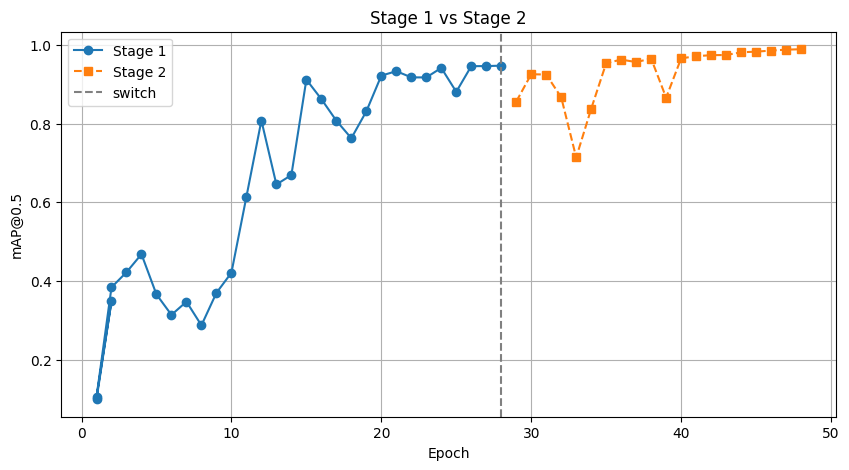

In [19]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load metrics from trained_models (make sure these files now exist)
df1 = pd.read_csv(Path(trained_dir)/f"{STAGE1_NAME}_metrics.csv", index_col="epoch")
df2 = pd.read_csv(Path(trained_dir)/f"{STAGE2_NAME}_metrics.csv", index_col="epoch")

# Prepare data
df1 = df1.iloc[:30]            # Stage 1: epochs 1–30
epochs1 = df1.index
epochs2 = df2.index + epochs1.max()  # Stage 2: 31–50

# Plot
plt.figure(figsize=(10,5))
plt.plot(epochs1, df1["metrics/mAP50(B)"], 'o-', label="Stage 1")
plt.plot(epochs2, df2["metrics/mAP50(B)"], 's--', label="Stage 2")
plt.axvline(epochs1.max(), color='gray', linestyle='--', label='switch')
plt.xlabel("Epoch"); plt.ylabel("mAP@0.5")
plt.title("Stage 1 vs Stage 2")
plt.legend(); plt.grid(True); plt.show()


In [24]:
# Cell 7: Expanded Parameter Sweep with Dry‐Run Check

import os, torch, shutil
from ultralytics import YOLO

# 🔧 MPS tweaks: disable high-watermark and clear cache
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# Dry‐run settings
DRY_RUN     = False    # first pass: True → 1 epoch
DRY_EPOCHS  = 1
FULL_EPOCHS = EPOCHS2

# Base checkpoint
base_ckpt = get_checkpoint(STAGE2_NAME)

# Extended hyperparameter experiments
param_exps = [
    # Learning rates
    ("lr_1e-3",      {"lr0": 1e-3}),
    ("lr_5e-4",      {"lr0": 5e-4}),
    ("lr_1e-4",      {"lr0": 1e-4}),
    # Weight decay
    ("wd_1e-2",      {"weight_decay": 1e-2}),
    ("wd_1e-3",      {"weight_decay": 1e-3}),
    ("wd_1e-4",      {"weight_decay": 1e-4}),
    # Augmentations
    ("mosaic_off",   {"mosaic": 0.0}),
    ("mixup_on",     {"mixup": 0.5}),         # 50% mixup
    ("label_smooth", {"label_smoothing": 0.1}),
    # LR schedules
    ("cosine_lr",    {"cos_lr": True}),
    
]

for tag, override in param_exps:
    # 🔧 clear cache for each iteration
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

    run_name = f"exp_{tag}"
    epochs   = DRY_EPOCHS if DRY_RUN else FULL_EPOCHS
    print(f"\n▶️ {'Dry-run' if DRY_RUN else 'Full'} training '{run_name}' for {epochs} epoch(s) with {override}")

    # 1) Train
    result = YOLO(base_ckpt).train(
        data=DATA_YAML,
        epochs=epochs,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        freeze=0,
        device=DEVICE,
        name=run_name,
        save=True,
        exist_ok=True,
        verbose=False,
        max_det=100,
        **override
    )

    # 2) Copy out best checkpoint
    ckpt = get_checkpoint(run_name)
    dst_ckpt = trained_dir / f"{run_name}_best.pt"
    shutil.copy2(ckpt, dst_ckpt)
    print(f"✅ Saved checkpoint → {dst_ckpt}")

    # 3) Copy out results.csv so you have metrics for each run
    src_csv = proj_root / "runs" / "detect" / run_name / "results.csv"
    dst_csv = trained_dir / f"{run_name}_metrics.csv"
    try:
        shutil.copy2(src_csv, dst_csv)
        print(f"✅ Saved metrics → {dst_csv}")
    except FileNotFoundError:
        print(f"⚠️ No results.csv found for {run_name}, skipping metrics copy")

print("\n✅ All parameter‐sweep dry-runs complete. When ready, set DRY_RUN=False to run full experiments.")  



▶️ Full training 'exp_lr_1e-3' for 20 epoch(s) with {'lr0': 0.001}
New https://pypi.org/project/ultralytics/8.3.139 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=/Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_stage2/weights/best.pt, data=/Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=exp_lr_1e-3, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=100, half=False, dnn=False, plots=True, source=None, v

train: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/train/labels.cache... 424 images, 0 backgrounds, 0 corrupt: 100%|██████████| 424/424 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 71.7±20.6 MB/s, size: 11.9 KB)



val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels.cache... 319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<?, ?it/s]

Plotting labels to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr_1e-3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr_1e-3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.68G     0.9696     0.8424      1.061         52        640:   7%|▋         | 2/27 [00:03<00:42,  1.69s/it]


KeyboardInterrupt: 

In [25]:
# Cell 8: Evaluate Parameter‐Sweep Experiments + Baseline

from ultralytics import YOLO
import pandas as pd

# 1) Baseline is your Stage 2 run with no overrides
baseline_tag = "baseline"
baseline_run = STAGE2_NAME  # e.g. "subblock_stage2_mps"

# 2) Your parameter-sweep tags
exp_tags = [tag for tag, _ in param_exps]  # ["lr0_5e-4","wd_1e-3","mosaic_on","cosine_lr"]

# 3) Collect final-epoch train mAP for baseline + experiments
train_summary = []

# Baseline row
try:
    df_base = load_metrics(baseline_run)
    last_base = df_base.iloc[-1]
    train_summary.append({
        "exp": baseline_tag,
        "train_mAP50":    last_base["metrics/mAP50(B)"],
        "train_mAP50-95": last_base["metrics/mAP50-95(B)"]
    })
except FileNotFoundError:
    train_summary.append({"exp": baseline_tag, "train_mAP50": None, "train_mAP50-95": None})

# Parameter-sweep rows
for tag in exp_tags:
    run_name = f"exp_{tag}"
    try:
        df = load_metrics(run_name)
        last_row = df.iloc[-1]
        train_summary.append({
            "exp": tag,
            "train_mAP50":    last_row["metrics/mAP50(B)"],
            "train_mAP50-95": last_row["metrics/mAP50-95(B)"]
        })
    except FileNotFoundError:
        train_summary.append({"exp": tag, "train_mAP50": None, "train_mAP50-95": None})

train_df = pd.DataFrame(train_summary).set_index("exp")
print("=== Training Summary (final epoch) ===")
display(train_df)

# 4) Evaluate each on TEST split
test_summary = []

# Baseline
print(f"▶️ Evaluating baseline '{baseline_run}' on TEST split…")
base_ckpt = get_checkpoint(baseline_run)
base_model = YOLO(base_ckpt)
res_base = base_model.val(data=DATA_YAML, device=DEVICE, split="test", verbose=False)
test_summary.append({
    "exp": baseline_tag,
    "test_mAP50":    float(res_base.box.map50),
    "test_mAP50-95": float(res_base.box.map)
})

# Parameter-sweep
for tag in exp_tags:
    run_name = f"exp_{tag}"
    print(f"▶️ Evaluating '{run_name}' on TEST split…")
    ckpt = get_checkpoint(run_name)
    model = YOLO(ckpt)
    res = model.val(data=DATA_YAML, device=DEVICE, split="test", verbose=False)
    test_summary.append({
        "exp": tag,
        "test_mAP50":    float(res.box.map50),
        "test_mAP50-95": float(res.box.map)
    })

test_df = pd.DataFrame(test_summary).set_index("exp")
print("\n=== Test‐Set Evaluation ===")
display(test_df)

# 5) Combine baseline + experiments
comparison = train_df.join(test_df)
print("\n=== Combined Comparison ===")
display(comparison)


=== Training Summary (final epoch) ===


,train_mAP50,train_mAP50-95
exp,,
baseline,0.98970,0.76814
lr_1e-3,0.99212,0.80171
lr_5e-4,0.99212,0.80171
lr_1e-4,0.99212,0.80171
wd_1e-2,0.99273,0.80018
wd_1e-3,0.99290,0.80184
wd_1e-4,0.99301,0.80212
mosaic_off,0.99446,0.81774
mixup_on,0.98626,0.77759


▶️ Evaluating baseline 'exp_stage2' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 56.9±10.0 MB/s, size: 9.5 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


                   all        315        491      0.969      0.976       0.99      0.767
Speed: 0.5ms preprocess, 5.1ms inference, 0.0ms loss, 8.2ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val16
▶️ Evaluating 'exp_lr_1e-3' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 218.7±64.3 MB/s, size: 9.9 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


                   all        315        491      0.968      0.995      0.992      0.798
Speed: 0.5ms preprocess, 4.9ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val17
▶️ Evaluating 'exp_lr_5e-4' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 225.4±102.6 MB/s, size: 9.5 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


                   all        315        491      0.968      0.995      0.992      0.798
Speed: 0.4ms preprocess, 4.8ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val18
▶️ Evaluating 'exp_lr_1e-4' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 637.6±197.2 MB/s, size: 11.9 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


                   all        315        491      0.968      0.995      0.992      0.798
Speed: 0.5ms preprocess, 4.9ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val19
▶️ Evaluating 'exp_wd_1e-2' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 594.4±201.2 MB/s, size: 11.1 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


                   all        315        491      0.975          1      0.992      0.795
Speed: 0.4ms preprocess, 4.8ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val20
▶️ Evaluating 'exp_wd_1e-3' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 523.3±228.1 MB/s, size: 9.6 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


                   all        315        491      0.975      0.995      0.992      0.796
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val21
▶️ Evaluating 'exp_wd_1e-4' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 645.8±198.3 MB/s, size: 11.9 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


                   all        315        491      0.972       0.99      0.992      0.798
Speed: 0.6ms preprocess, 4.7ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val22
▶️ Evaluating 'exp_mosaic_off' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 614.2±233.2 MB/s, size: 11.0 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


                   all        315        491      0.974      0.996      0.994      0.816
Speed: 0.5ms preprocess, 4.7ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val23
▶️ Evaluating 'exp_mixup_on' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 604.9±293.9 MB/s, size: 13.1 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


                   all        315        491      0.973      0.989       0.99      0.773
Speed: 0.6ms preprocess, 5.3ms inference, 0.0ms loss, 8.4ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val24
▶️ Evaluating 'exp_label_smooth' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 624.9±239.9 MB/s, size: 11.3 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


                   all        315        491      0.968      0.995      0.992      0.798
Speed: 0.4ms preprocess, 4.9ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val25
▶️ Evaluating 'exp_cosine_lr' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 610.0±215.0 MB/s, size: 10.8 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


                   all        315        491      0.972      0.983      0.993      0.792
Speed: 0.5ms preprocess, 5.1ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val26

=== Test‐Set Evaluation ===


,test_mAP50,test_mAP50-95
exp,,
baseline,0.990481,0.766651
lr_1e-3,0.992129,0.797983
lr_5e-4,0.992129,0.797983
lr_1e-4,0.992129,0.797983
wd_1e-2,0.992188,0.794721
wd_1e-3,0.992293,0.795789
wd_1e-4,0.991998,0.798015
mosaic_off,0.993513,0.816086
mixup_on,0.989715,0.773262



=== Combined Comparison ===


,train_mAP50,train_mAP50-95,test_mAP50,test_mAP50-95
exp,,,,
baseline,0.98970,0.76814,0.990481,0.766651
lr_1e-3,0.99212,0.80171,0.992129,0.797983
lr_5e-4,0.99212,0.80171,0.992129,0.797983
lr_1e-4,0.99212,0.80171,0.992129,0.797983
wd_1e-2,0.99273,0.80018,0.992188,0.794721
wd_1e-3,0.99290,0.80184,0.992293,0.795789
wd_1e-4,0.99301,0.80212,0.991998,0.798015
mosaic_off,0.99446,0.81774,0.993513,0.816086
mixup_on,0.98626,0.77759,0.989715,0.773262


In [26]:
# Cell 9: Single‐Stage Full Unfreeze 50-Epoch from Original Pretrained Model

from ultralytics import YOLO
import shutil, os, torch

# 🔧 Disable MPS high-watermark and clear cache
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# 1) Use the original pretrained model as the starting point
base_ckpt = ORIG_MODEL  # yolov8_original.pt

# 2) Define experiment parameters
EXP_NAME = "exp_orig_full50"
EPOCHS   = 50

# 3) Run full unfreeze training
print(f"▶️ Training '{EXP_NAME}' for {EPOCHS} epochs starting from {base_ckpt}")
results = YOLO(base_ckpt).train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,     # ↳ drop to 512 or 416 if needed
    batch=BATCH_SIZE,   # ↳ lower to 8 or 4 if you see OOM
    freeze=0,           # unfreeze all layers
    device=DEVICE,
    name=EXP_NAME,
    save=True,
    exist_ok=True,
    verbose=False,
    max_det=100
)
print("✅ Training complete.")

# 4) Copy the resulting best.pt into trained_models/
ckpt_path = get_checkpoint(EXP_NAME)
dst_path  = trained_dir / f"{EXP_NAME}_best.pt"
shutil.copy2(ckpt_path, dst_path)
print(f"✅ Saved '{EXP_NAME}' best.pt to:\n   {dst_path}")

# 5) Copy out results.csv so you have the epoch‐wise metrics
try:
    src_csv = proj_root / "runs" / "detect" / EXP_NAME / "results.csv"
    dst_csv = trained_dir / f"{EXP_NAME}_metrics.csv"
    shutil.copy2(src_csv, dst_csv)
    print(f"✅ Saved metrics → {dst_csv}")
except FileNotFoundError:
    print(f"⚠️ Could not find results.csv in runs/detect/{EXP_NAME}, skipping metrics copy")


▶️ Training 'exp_orig_full50' for 50 epochs starting from /Users/fatihbasturk/Projects/EE58A-2025/trained_models/yolov8_original.pt
New https://pypi.org/project/ultralytics/8.3.139 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=/Users/fatihbasturk/Projects/EE58A-2025/trained_models/yolov8_original.pt, data=/Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=exp_orig_full50, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7,

train: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/train/labels.cache... 424 images, 0 backgrounds, 0 corrupt: 100%|██████████| 424/424 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 62.6±33.6 MB/s, size: 11.9 KB)



val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels.cache... 319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<?, ?it/s]

Plotting labels to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.43G      2.243      3.844      1.957         21        640: 100%|██████████| 27/27 [00:40<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:06<01:02,  6.93s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:13<00:52,  6.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:19<00:44,  6.42s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:25<00:38,  6.35s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:31<00:30,  6.17s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:37<00:24,  6.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:43<00:17,  5.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:49<00:12,  6.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:55<00:06,  6.10s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:03<00:00,  6.33s/it]

                   all        319        514     0.0173      0.609      0.101     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.52G      1.592      2.703      1.413         23        640: 100%|██████████| 27/27 [00:46<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:04<00:43,  4.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:10<00:40,  5.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:16<00:39,  5.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:22<00:34,  5.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:27<00:28,  5.60s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:33<00:22,  5.66s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:39<00:17,  5.70s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:45<00:12,  6.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:51<00:05,  5.90s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:57<00:00,  5.72s/it]

                   all        319        514      0.508      0.273      0.281      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.64G      1.414      2.099      1.297         24        640: 100%|██████████| 27/27 [00:50<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:04<00:43,  4.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:09<00:39,  5.00s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:16<00:40,  5.81s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:22<00:34,  5.79s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:28<00:28,  5.76s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:33<00:22,  5.67s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:39<00:17,  5.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:45<00:11,  5.90s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:51<00:05,  5.91s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:57<00:00,  5.72s/it]

                   all        319        514      0.678      0.356      0.354       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.74G      1.378      1.807      1.281         21        640: 100%|██████████| 27/27 [01:11<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:04<00:44,  4.93s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:10<00:41,  5.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:16<00:41,  5.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:22<00:34,  5.70s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:27<00:28,  5.65s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:33<00:22,  5.69s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:39<00:17,  5.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:46<00:12,  6.04s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:51<00:05,  5.84s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:57<00:00,  5.73s/it]

                   all        319        514      0.702      0.305        0.3      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.88G      1.321      1.562      1.284         25        640: 100%|██████████| 27/27 [01:30<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:05<00:45,  5.07s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:10<00:43,  5.42s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:18<00:44,  6.31s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:23<00:36,  6.00s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:29<00:29,  5.82s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:34<00:23,  5.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:41<00:17,  5.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:47<00:12,  6.01s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:52<00:05,  5.82s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:58<00:00,  5.82s/it]

                   all        319        514      0.692      0.265      0.265      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        10G       1.24      1.421      1.256         16        640: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:05<00:52,  5.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:11<00:45,  5.69s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:17<00:41,  5.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:23<00:34,  5.82s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:29<00:29,  5.88s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:34<00:22,  5.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:40<00:17,  5.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:46<00:11,  5.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:52<00:05,  5.75s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:58<00:00,  5.83s/it]

                   all        319        514      0.828      0.266      0.275      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.1G      1.218      1.317       1.22         22        640: 100%|██████████| 27/27 [01:32<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:04<00:43,  4.87s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:10<00:44,  5.51s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:16<00:38,  5.57s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:22<00:33,  5.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:27<00:27,  5.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:33<00:22,  5.53s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:38<00:16,  5.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:44<00:11,  5.66s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:50<00:05,  5.60s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:55<00:00,  5.57s/it]

                   all        319        514      0.786      0.312      0.331      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.2G      1.194      1.221      1.207         26        640: 100%|██████████| 27/27 [01:46<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:04<00:43,  4.82s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:10<00:41,  5.21s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:16<00:39,  5.63s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:23<00:36,  6.09s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:30<00:32,  6.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:36<00:24,  6.23s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:42<00:18,  6.11s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:48<00:12,  6.11s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:53<00:05,  5.96s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:59<00:00,  5.94s/it]


                   all        319        514      0.877      0.332      0.355      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.3G      1.195      1.186      1.224         27        640: 100%|██████████| 27/27 [01:51<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:04<00:43,  4.88s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:10<00:42,  5.28s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:16<00:40,  5.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:22<00:35,  5.93s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:28<00:28,  5.80s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:34<00:23,  5.87s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:46<00:11,  5.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [00:53<00:06,  6.18s/it]

WARNING ⚠️ NMS time limit 3.550s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


                   all        319        514      0.899       0.59      0.623        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.5G      1.168      1.114      1.216         18        640: 100%|██████████| 27/27 [01:53<00:00,  4.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:51<00:00,  5.20s/it]

                   all        319        514      0.914      0.853      0.912      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.6G      1.159      1.055      1.214         32        640: 100%|██████████| 27/27 [01:56<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:12<01:51, 12.43s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:27<01:52, 14.08s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:35<01:19, 11.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:46<01:07, 11.24s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [01:05<00:40, 10.16s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [01:17<00:32, 10.78s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


                   all        319        514      0.935      0.725      0.772       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.7G       1.14      1.055      1.204         29        640: 100%|██████████| 27/27 [02:16<00:00,  5.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:01<00:00,  6.10s/it]

                   all        319        514      0.921      0.879      0.932      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.9G      1.116      1.038      1.185         29        640: 100%|██████████| 27/27 [02:10<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]

                   all        319        514      0.945      0.879      0.935      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.1G      1.119      1.001      1.188         31        640: 100%|██████████| 27/27 [02:09<00:00,  4.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


                   all        319        514      0.962      0.874      0.934      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.2G      1.106     0.9792      1.186         22        640: 100%|██████████| 27/27 [02:37<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:35<00:00,  3.50s/it]

                   all        319        514      0.959      0.892      0.944      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.4G      1.097     0.9376      1.184         28        640: 100%|██████████| 27/27 [02:39<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]

                   all        319        514      0.937      0.898      0.942      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.6G      1.088     0.9329      1.182         33        640: 100%|██████████| 27/27 [02:07<00:00,  4.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


                   all        319        514       0.96      0.896      0.951      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.8G      1.082      0.884      1.176         27        640: 100%|██████████| 27/27 [02:18<00:00,  5.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


                   all        319        514      0.953      0.896      0.963      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50        12G      1.082     0.8916      1.165         19        640: 100%|██████████| 27/27 [02:49<00:00,  6.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:36<00:00,  3.65s/it]

                   all        319        514      0.951      0.892      0.954      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      12.2G      1.057      0.883       1.16         24        640: 100%|██████████| 27/27 [02:37<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


                   all        319        514      0.965      0.894      0.965      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      12.4G      1.034     0.8452      1.156         23        640: 100%|██████████| 27/27 [02:27<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


                   all        319        514      0.937      0.903      0.962      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.6G      1.046     0.8209      1.163         17        640: 100%|██████████| 27/27 [02:45<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


                   all        319        514      0.938      0.899      0.961      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.9G      1.052     0.8355      1.156         24        640: 100%|██████████| 27/27 [03:00<00:00,  6.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


                   all        319        514      0.976      0.904      0.973      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      13.1G      1.012     0.8125      1.135         32        640: 100%|██████████| 27/27 [02:32<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


                   all        319        514      0.971      0.921      0.973      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      13.3G      1.017     0.7957      1.132         21        640: 100%|██████████| 27/27 [03:13<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


                   all        319        514      0.963      0.915      0.973      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      13.5G     0.9818     0.7775      1.119         29        640: 100%|██████████| 27/27 [02:16<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


                   all        319        514      0.976      0.906      0.971      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.7G      1.014     0.7837      1.133         34        640: 100%|██████████| 27/27 [02:44<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


                   all        319        514       0.97      0.917      0.973      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.9G     0.9908     0.7372       1.13         19        640: 100%|██████████| 27/27 [03:18<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


                   all        319        514      0.978       0.92      0.973      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      14.1G      0.982     0.7596      1.138         25        640: 100%|██████████| 27/27 [03:31<00:00,  7.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


                   all        319        514       0.97      0.934      0.976      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      14.4G      0.985     0.7375      1.135         24        640: 100%|██████████| 27/27 [03:41<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


                   all        319        514      0.947      0.939      0.979      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      14.5G     0.9538     0.7303      1.107         27        640: 100%|██████████| 27/27 [03:34<00:00,  7.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


                   all        319        514      0.972       0.93      0.979      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      14.8G     0.9564     0.7164      1.114         38        640: 100%|██████████| 27/27 [49:25<00:00, 109.83s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]

                   all        319        514      0.944      0.949      0.979      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50        15G     0.9509     0.6954      1.103         29        640: 100%|██████████| 27/27 [08:11<00:00, 18.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


                   all        319        514      0.965      0.937      0.982      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      15.2G     0.9374     0.7185      1.098         21        640: 100%|██████████| 27/27 [03:05<00:00,  6.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


                   all        319        514      0.967      0.959      0.985      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      15.4G     0.9483     0.6968       1.11         35        640: 100%|██████████| 27/27 [03:37<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


                   all        319        514      0.965      0.943      0.984      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      15.6G     0.9265     0.7095      1.096         26        640: 100%|██████████| 27/27 [02:48<00:00,  6.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


                   all        319        514       0.97      0.952      0.984      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      15.8G       0.93     0.6753      1.096         24        640: 100%|██████████| 27/27 [03:18<00:00,  7.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


                   all        319        514      0.944      0.984      0.987       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        16G       0.93     0.6786      1.093         22        640: 100%|██████████| 27/27 [05:12<00:00, 11.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


                   all        319        514      0.961      0.978      0.989      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      16.1G     0.9261     0.6747      1.095         21        640: 100%|██████████| 27/27 [04:19<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


                   all        319        514      0.949      0.987      0.987      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      16.4G     0.9325     0.6961      1.096         27        640: 100%|██████████| 27/27 [04:28<00:00,  9.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


                   all        319        514      0.975      0.959      0.988      0.773
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      16.6G     0.8338     0.5518      1.047         13        640: 100%|██████████| 27/27 [08:10<00:00, 18.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


                   all        319        514       0.95      0.974      0.987      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      16.8G     0.8261     0.5368      1.044          9        640: 100%|██████████| 27/27 [04:48<00:00, 10.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


                   all        319        514      0.956       0.96      0.987      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50        17G     0.8137      0.503      1.035         16        640: 100%|██████████| 27/27 [03:19<00:00,  7.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


                   all        319        514      0.951      0.985      0.988       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      17.2G     0.8319     0.5071      1.049         19        640: 100%|██████████| 27/27 [04:13<00:00,  9.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


                   all        319        514      0.962      0.989      0.991      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      17.4G     0.7974     0.4885      1.034         13        640: 100%|██████████| 27/27 [04:08<00:00,  9.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


                   all        319        514      0.955      0.991       0.99      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      17.6G     0.7981     0.4824      1.018         17        640: 100%|██████████| 27/27 [05:08<00:00, 11.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


                   all        319        514      0.959      0.993       0.99      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      17.8G     0.7881      0.491      1.024          9        640: 100%|██████████| 27/27 [03:51<00:00,  8.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


                   all        319        514      0.962      0.995       0.99      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        18G     0.7703     0.4754      1.018         16        640: 100%|██████████| 27/27 [05:20<00:00, 11.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [02:50<00:00, 17.09s/it]


                   all        319        514      0.959       0.99       0.99      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      18.1G      0.774      0.464      1.012         11        640: 100%|██████████| 27/27 [19:14<00:00, 42.78s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


                   all        319        514      0.956      0.987      0.989      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      18.3G     0.7826     0.4738      1.014         12        640: 100%|██████████| 27/27 [13:44<00:00, 30.53s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


                   all        319        514       0.96      0.989       0.99      0.793

50 epochs completed in 4.393 hours.
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/weights/last.pt, 6.2MB
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/weights/best.pt, 6.2MB

Validating /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [10:15<00:00, 61.54s/it] 


                   all        319        514      0.962       0.99      0.991      0.796
Speed: 2.6ms preprocess, 1101.0ms inference, 0.0ms loss, 9.7ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50
✅ Training complete.
✅ Saved 'exp_orig_full50' best.pt to:
   /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_orig_full50_best.pt
✅ Saved metrics → /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_orig_full50_metrics.csv


In [27]:
# Cell 11: Final test-set evaluation (fixed)

from ultralytics import YOLO

model = YOLO(trained_dir/"exp_orig_full50_best.pt")
results = model.val(data=DATA_YAML, device=DEVICE, split="test")

# Print per-class AP and overall mAP
for i, name in results.names.items():
    ap50   = results.box.ap50[i]
    ap5095 = results.box.ap[i]
    print(f"{name:20s}  AP@0.5={ap50:.3f}  AP@0.5-0.95={ap5095:.3f}")

# Access map50 and map as attributes, not methods
print(f"\nOverall mAP@0.5    = {results.box.map50:.3f}")
print(f"Overall mAP@0.5-0.95 = {results.box.map:.3f}")


Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 62.0±17.8 MB/s, size: 9.7 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


                   all        315        491      0.965      0.985      0.986      0.785
     differential_pair        184        194      0.983       0.99      0.989      0.812
               cascode         51         69      0.944      0.978      0.987      0.731
        current_mirror        155        228      0.968      0.987      0.982      0.811
Speed: 5.4ms preprocess, 15.2ms inference, 0.0ms loss, 13.1ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val27
differential_pair     AP@0.5=0.989  AP@0.5-0.95=0.812
cascode               AP@0.5=0.987  AP@0.5-0.95=0.731
current_mirror        AP@0.5=0.982  AP@0.5-0.95=0.811

Overall mAP@0.5    = 0.986
Overall mAP@0.5-0.95 = 0.785


=== Benchmark Training Metrics (exp_orig_full50) ===


,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
1,104.153,2.24258,3.84435,1.95720,0.01733,0.60869,0.10117,0.04994,1.62963,3.06050,1.41988,0.000372,0.000372,0.000372
2,209.511,1.59225,2.70341,1.41269,0.50824,0.27294,0.28139,0.16367,1.45007,2.03570,1.30154,0.000742,0.000742,0.000742
3,318.947,1.41443,2.09852,1.29693,0.67805,0.35630,0.35360,0.21001,1.30153,1.68044,1.24859,0.001098,0.001098,0.001098
4,448.976,1.37843,1.80684,1.28115,0.70171,0.30523,0.29988,0.17786,1.34294,1.48065,1.28600,0.001344,0.001344,0.001344
5,598.666,1.32092,1.56196,1.28366,0.69187,0.26496,0.26476,0.16710,1.18478,1.28520,1.24227,0.001316,0.001316,0.001316


,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
46,12910.0,0.79813,0.48240,1.01758,0.95858,0.99254,0.98954,0.78923,0.73134,0.42932,0.99020,0.000156,0.000156,0.000156
47,13217.7,0.78815,0.49104,1.02371,0.96219,0.99502,0.99050,0.79593,0.71958,0.42208,0.98188,0.000127,0.000127,0.000127
48,13736.1,0.77034,0.47538,1.01760,0.95929,0.99013,0.99028,0.79423,0.72028,0.42143,0.98247,0.000099,0.000099,0.000099
49,14948.1,0.77402,0.46398,1.01199,0.95624,0.98654,0.98907,0.79221,0.71883,0.41955,0.98451,0.000071,0.000071,0.000071
50,15811.8,0.78265,0.47382,1.01414,0.96045,0.98855,0.98960,0.79284,0.72174,0.41798,0.98743,0.000043,0.000043,0.000043


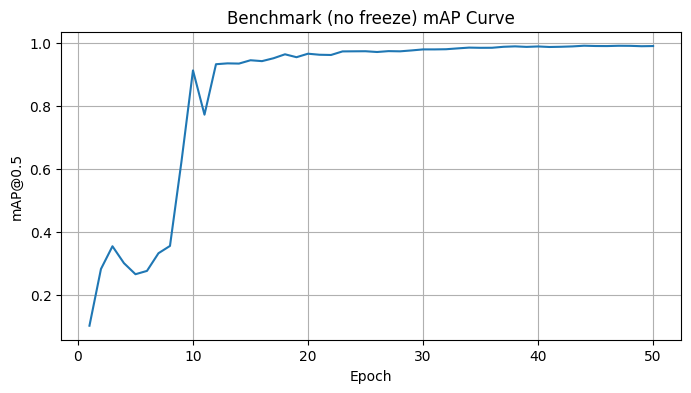

In [29]:
# Cell 10: Load & Display Training Metrics for the Benchmark

# 1) Load the epoch‐wise metrics for exp_orig_full50
df_bench = load_metrics("exp_orig_full50")

# 2) Show the first & last few rows so you can inspect convergence
print("=== Benchmark Training Metrics (exp_orig_full50) ===")
display(df_bench.head(), df_bench.tail())

# 3) (Optional) Plot its mAP curve for quick visual check
plt.figure(figsize=(8,4))
plt.plot(df_bench.index, df_bench["metrics/mAP50(B)"], label="benchmark mAP@0.5")
plt.xlabel("Epoch"); plt.ylabel("mAP@0.5")
plt.title("Benchmark (no freeze) mAP Curve"); plt.grid(True); plt.show()


In [31]:
# Cell Y: Final Test‐Set Evaluation Comparison

from ultralytics import YOLO
import pandas as pd

# Map friendly tags to your actual run names
comparison_runs = [
    ("Stage1+2", STAGE2_NAME),   # two‐stage fine-tune
    ("One-Shot", "exp_orig_full50")  # one‐shot full unfreeze
]

results = []
for tag, run_name in comparison_runs:
    ckpt = get_checkpoint(run_name)
    model = YOLO(ckpt)
    print(f"▶️ Evaluating {tag} ({run_name}) on TEST split…")
    res = model.val(
        data=DATA_YAML,
        device=DEVICE,
        split="test",
        verbose=False
    )
    results.append({
        "model":        tag,
        "test_mAP50":   float(res.box.map50),
        "test_mAP50-95":float(res.box.map),
        "Precision":    float(res.box.p.mean()),
        "Recall":       float(res.box.r.mean())
    })

# Build and display the comparison table
df_compare = pd.DataFrame(results).set_index("model")
display(df_compare)


▶️ Evaluating Stage1+2 (exp_stage2) on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 64.8±19.4 MB/s, size: 9.6 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


                   all        315        491      0.969      0.976       0.99      0.767
Speed: 0.4ms preprocess, 5.6ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val28
▶️ Evaluating One-Shot (exp_orig_full50) on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 571.5±119.1 MB/s, size: 10.4 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


                   all        315        491      0.965      0.993      0.991      0.789
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val29


,test_mAP50,test_mAP50-95,Precision,Recall
model,,,,
Stage1+2,0.990481,0.766651,0.969495,0.975845
One-Shot,0.990813,0.789095,0.965254,0.992776


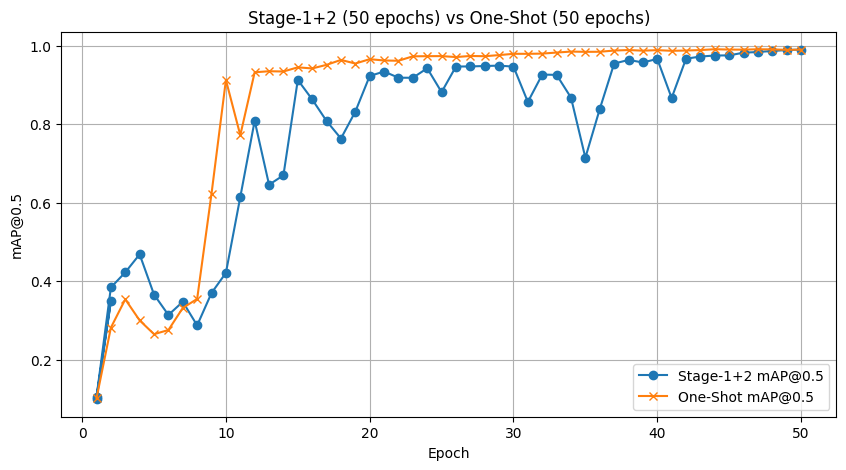

In [32]:
# Cell X: Plot Stage-1+2 (50 epochs) vs One-Shot (50 epochs)

import matplotlib.pyplot as plt
import pandas as pd

# Run names
run_stage1 = STAGE1_NAME       # e.g. "subblock_stage1_mps"
run_stage2 = STAGE2_NAME       # e.g. "subblock_stage2_mps"
run_bench  = "exp_orig_full50" # your one-shot run

# 1) Load metrics
df1 = load_metrics(run_stage1)              # head-only warmup epochs
df2 = load_metrics(run_stage2)              # full fine-tune epochs
df_b = load_metrics(run_bench)              # one-shot epochs

# 2) Offset Stage-2 epochs so they follow Stage-1
df2_off = df2.copy()
df2_off.index = df2_off.index + df1.index.max()

# 3) Concatenate the two-stage series
series_stage12 = pd.concat([
    df1["metrics/mAP50(B)"],
    df2_off["metrics/mAP50(B)"]
])

# 4) Plot
plt.figure(figsize=(10,5))
plt.plot(series_stage12.index, series_stage12.values, marker='o', label="Stage-1+2 mAP@0.5")
plt.plot(df_b.index, df_b["metrics/mAP50(B)"].values, marker='x', label="One-Shot mAP@0.5")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.title("Stage-1+2 (50 epochs) vs One-Shot (50 epochs)")
plt.legend()
plt.grid(True)
plt.show()


⚠️ Missing exp_warmup_lr_metrics.csv


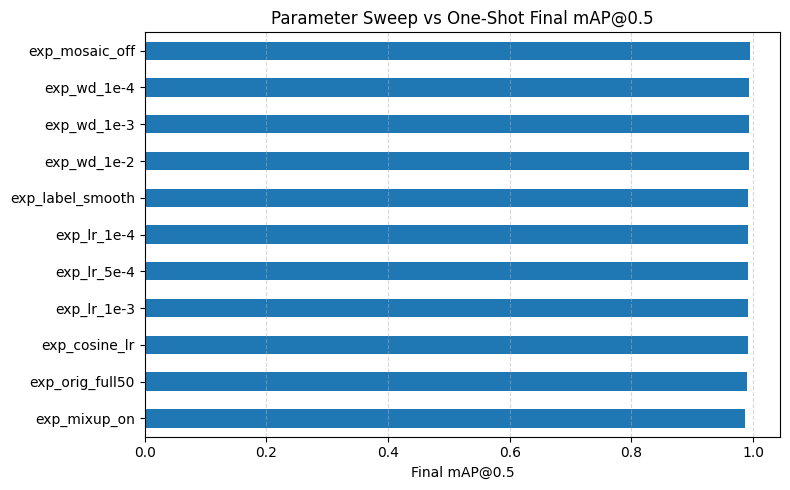

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) List your sweep tags (the same tags you used in Cell 7)
sweep_tags = [
    "exp_lr_1e-3", "exp_lr_5e-4", "exp_lr_1e-4",
    "exp_wd_1e-2", "exp_wd_1e-3", "exp_wd_1e-4",
    "exp_mosaic_off", "exp_mixup_on", "exp_label_smooth",
    "exp_cosine_lr"
]

# 2) Define the One-Shot tag
one_shot_tag = "exp_orig_full50"

# 3) Path to your trained_models folder
tm = Path(trained_dir)

# 4) Gather final mAP50 from metrics CSVs
summary = {}
for tag in sweep_tags + [one_shot_tag]:
    csv = tm / f"{tag}_metrics.csv"
    if not csv.exists():
        print(f"⚠️ Missing {csv.name}")
        continue
    df = pd.read_csv(csv, index_col="epoch")
    # dedupe Stage 2 if duplicates (optional)
    df = df[~df.index.duplicated(keep="first")]
    summary[tag] = df["metrics/mAP50(B)"].iloc[-1]

# 5) Build a Series and sort (optional)
s = pd.Series(summary).sort_values()

# 6) Plot bar chart
plt.figure(figsize=(8, 5))
s.plot.barh()
plt.xlabel("Final mAP@0.5")
plt.title("Parameter Sweep vs One-Shot Final mAP@0.5")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [44]:
# Re‐import and re‐define everything you need
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path

# 0) Config
trained_dir   = Path(proj_root) / "trained_models"
sweep_tags    = [
    "exp_lr_1e-3", "exp_lr_5e-4", "exp_lr_1e-4",
    "exp_wd_1e-2","exp_wd_1e-3","exp_wd_1e-4",
    "exp_mosaic_off","exp_mixup_on","exp_label_smooth",
    "exp_cosine_lr","exp_warmup_lr"
]
one_shot_tag  = "exp_orig_full50"
default_tag   = STAGE2_NAME        # your two‐stage fine-tune baseline

# 1) Build summary of final epoch mAP50 for sweep + one-shot
summary = []
for tag in sweep_tags + [one_shot_tag]:
    csv = trained_dir / f"{tag}_metrics.csv"
    if not csv.exists(): continue
    df = pd.read_csv(csv, index_col="epoch")
    df = df[~df.index.duplicated(keep="first")]
    summary.append({
        "model": tag,
        "final_mAP50": df["metrics/mAP50(B)"].iloc[-1]
    })
summary_df = pd.DataFrame(summary).set_index("model").sort_values("final_mAP50")
display(summary_df)

# 2) Identify best sweep run
best_tag = summary_df["final_mAP50"].idxmax()
best_val = summary_df["final_mAP50"].max()
print(f"🔍 Best sweep run: {best_tag} with mAP@0.5 = {best_val:.3f}")

# 3) Test‐set comparison table (default Stage1+2, One-Shot, Best-Tuned)
cmp = []
for label, tag in [
    ("Stage1+2 (default)", default_tag),
    ("One-Shot", one_shot_tag),
    (f"Tuned ({best_tag})", best_tag)
]:
    ckpt = get_checkpoint(tag)
    res  = YOLO(ckpt).val(data=DATA_YAML, device=DEVICE, split="test", verbose=False)
    cmp.append({
        "model": label,
        "test_mAP50":    float(res.box.map50),
        "test_mAP50-95": float(res.box.map),
        "Precision":     float(res.box.p.mean()),
        "Recall":        float(res.box.r.mean())
    })
cmp_df = pd.DataFrame(cmp).set_index("model")
display(cmp_df)



,final_mAP50
model,
exp_mixup_on,0.98626
exp_orig_full50,0.98960
exp_cosine_lr,0.99101
exp_lr_1e-3,0.99212
exp_lr_5e-4,0.99212
exp_lr_1e-4,0.99212
exp_label_smooth,0.99212
exp_wd_1e-2,0.99273
exp_wd_1e-3,0.99290


🔍 Best sweep run: exp_mosaic_off with mAP@0.5 = 0.994
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 30.5±15.7 MB/s, size: 10.4 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


                   all        315        491      0.969      0.976       0.99      0.767
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val39
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 539.8±230.2 MB/s, size: 9.3 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


                   all        315        491      0.967      0.993      0.991      0.789
Speed: 0.5ms preprocess, 4.9ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val40
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 767.8±153.4 MB/s, size: 13.1 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


                   all        315        491      0.974      0.998      0.994      0.817
Speed: 0.4ms preprocess, 4.8ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val41


,test_mAP50,test_mAP50-95,Precision,Recall
model,,,,
Stage1+2 (default),0.990481,0.766651,0.969495,0.975845
One-Shot,0.990813,0.788794,0.966695,0.992700
Tuned (exp_mosaic_off),0.993530,0.817057,0.974176,0.998075


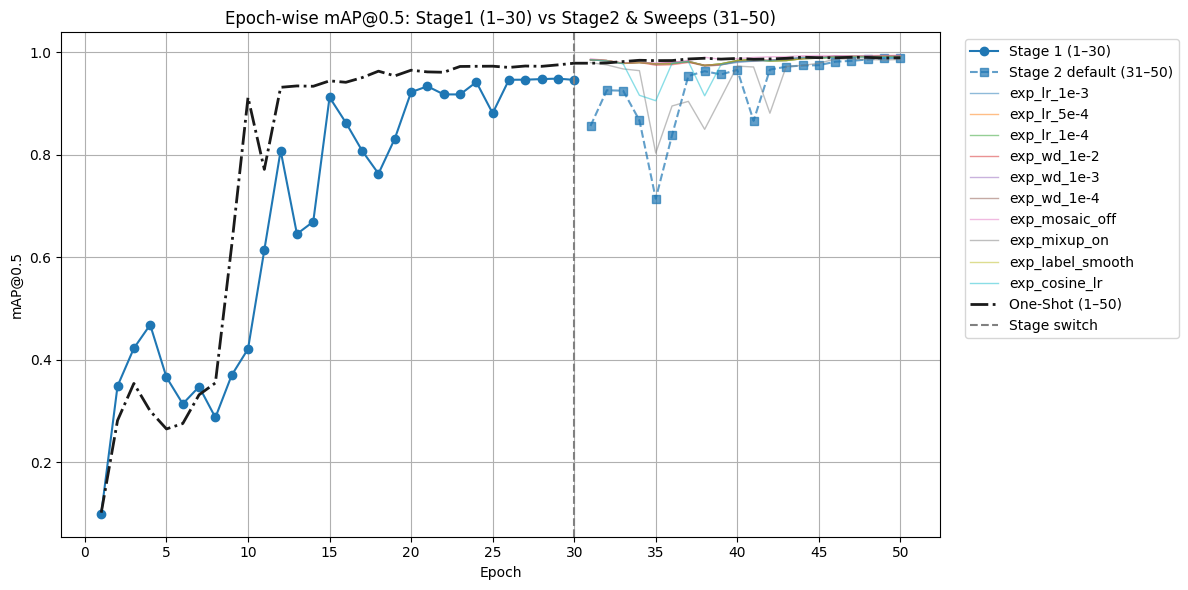

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Paths & run names
tm = Path(trained_dir)
stage1_csv     = tm / f"{STAGE1_NAME}_metrics.csv"
stage2_csv     = tm / f"{STAGE2_NAME}_metrics.csv"
one_shot_csv   = tm / "exp_orig_full50_metrics.csv"
sweep_tags     = [
    "exp_lr_1e-3", "exp_lr_5e-4", "exp_lr_1e-4",
    "exp_wd_1e-2","exp_wd_1e-3","exp_wd_1e-4",
    "exp_mosaic_off","exp_mixup_on","exp_label_smooth",
    "exp_cosine_lr","exp_warmup_lr"
]

# 2) Load DataFrames
df1 = pd.read_csv(stage1_csv, index_col="epoch")   # Stage1: epochs 1–30
df2 = pd.read_csv(stage2_csv, index_col="epoch")   # Stage2 default: epochs 1–20
# Dedupe Stage1 if needed:
df1 = df1[~df1.index.duplicated(keep="first")]

# 3) Prepare axes
map50    = "metrics/mAP50(B)"
e1       = df1.index                                    # 1–30
offset   = e1.max()                                     # 30
e2       = df2.index + offset                           # 31–50

# 4) Begin plot
plt.figure(figsize=(12,6))

# Stage 1
plt.plot(e1, df1[map50], 'o-', color='C0', label=f"Stage 1 (1–{offset})")

# Stage 2 default
plt.plot(e2, df2[map50], 's--', color='C0', alpha=0.7, label=f"Stage 2 default ({offset+1}–{offset+len(df2)})")

# Swept runs (only their 20-epoch runs, offset by +30)
for tag in sweep_tags:
    csv = tm / f"{tag}_metrics.csv"
    if not csv.exists(): 
        continue
    df = pd.read_csv(csv, index_col="epoch")
    df = df[~df.index.duplicated(keep="first")]
    plt.plot(df.index + offset,
             df[map50],
             linewidth=1,
             alpha=0.5,
             label=tag)

# (Optional) One-Shot full 1–50
if (one_shot_csv).exists():
    df_os = pd.read_csv(one_shot_csv, index_col="epoch")
    plt.plot(df_os.index,
             df_os[map50],
             'k-.',
             linewidth=2,
             label="One-Shot (1–50)")

# 5) Formatting
plt.axvline(offset, color='gray', linestyle='--', label="Stage switch")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.title("Epoch-wise mAP@0.5: Stage1 (1–30) vs Stage2 & Sweeps (31–50)")
plt.xticks(range(0, 51, 5))
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()


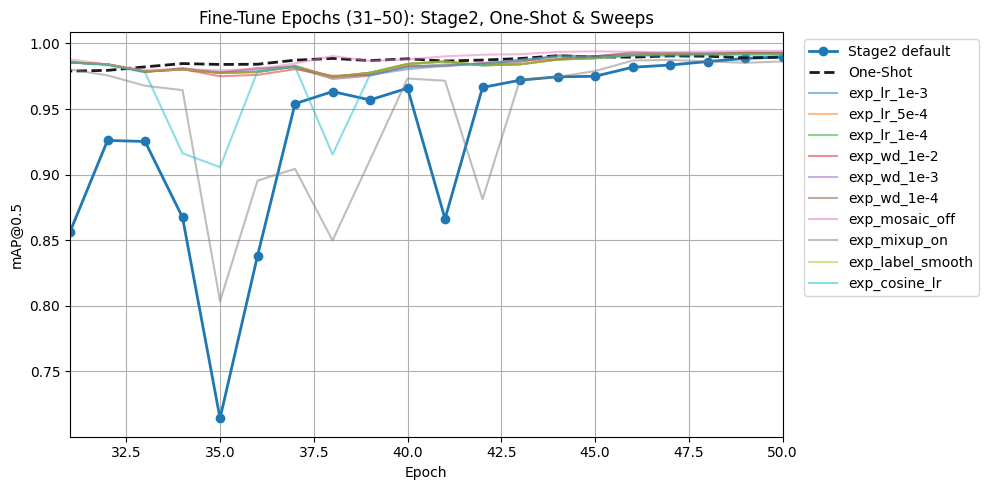

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 0) Configuration: adjust if your names differ
base_path     = Path("/Users/fatihbasturk/Projects/EE58A-2025") / "trained_models"
stage1_name   = "exp_stage1"
stage2_name   = "exp_stage2"
one_shot_name = "exp_orig_full50"
sweep_tags    = [
    "exp_lr_1e-3", "exp_lr_5e-4", "exp_lr_1e-4",
    "exp_wd_1e-2", "exp_wd_1e-3", "exp_wd_1e-4",
    "exp_mosaic_off", "exp_mixup_on", "exp_label_smooth",
    "exp_cosine_lr"
]

# 1) Load Stage 1 & Stage 2 data
df1 = pd.read_csv(base_path / f"{stage1_name}_metrics.csv", index_col="epoch")
df1 = df1[~df1.index.duplicated(keep="first")]  # dedupe
df2 = pd.read_csv(base_path / f"{stage2_name}_metrics.csv", index_col="epoch")
df2 = df2[~df2.index.duplicated(keep="first")]

# 2) Load One-Shot
df_one = pd.read_csv(base_path / f"{one_shot_name}_metrics.csv", index_col="epoch")
df_one = df_one[~df_one.index.duplicated(keep="first")]

# 3) Load sweeps into a dict
sweeps = {}
for tag in sweep_tags:
    path = base_path / f"{tag}_metrics.csv"
    if path.exists():
        df = pd.read_csv(path, index_col="epoch")
        df = df[~df.index.duplicated(keep="first")]
        sweeps[tag] = df


# 5) Plot fine-tune window (31–50)
offset = 30
plt.figure(figsize=(10,5))

# Stage 2 default
plt.plot(df2.index + offset, df2["metrics/mAP50(B)"],
         'o-', color='C0', lw=2, label="Stage2 default")

# One-Shot
df_one_slice = df_one[df_one.index >= offset]
plt.plot(df_one_slice.index, df_one_slice["metrics/mAP50(B)"],
         'k--', lw=2, label="One-Shot")

# Sweeps
for tag, df in sweeps.items():
    plt.plot(df.index + offset, df["metrics/mAP50(B)"],
             alpha=0.5, label=tag)

plt.xlim(31, 50)
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.title("Fine-Tune Epochs (31–50): Stage2, One-Shot & Sweeps")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()
